# Learning to predict whether there is one legal move or not

This is a simplified version in which the model only answers the question whether there is at least one legal move or not.

In [ ]:
from MorpionSolitaire import *
from DeepLearningMS import *
import numpy as np
import torch
from PIL import Image
from tqdm.notebook import trange

In [ ]:
from multiprocess import Pool
pool = Pool()

## Playing one game at a time

In [ ]:
def play_one_game(index = 0): # dummy argument needed for passing to pool.map
    game = NewGame('cross').play()
    grid1 = torch.FloatTensor(game.grid.image())
    game = game.unplay(np.random.randint(0, game.score))
    grid2 = torch.FloatTensor(game.grid.image())
    return torch.unsqueeze(torch.stack((grid1, grid2)), 1)

In [ ]:
def visualize(grid):
    return Image.fromarray(~np.array(torch.squeeze(grid)).astype('bool'))

In [ ]:
pair_of_games = play_one_game(0)

In [ ]:
pair_of_games.shape

torch.Size([2, 1, 94, 94])

In [ ]:
pair_of_games[0].shape

torch.Size([1, 94, 94])

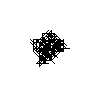

In [ ]:
visualize(pair_of_games[0])

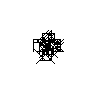

In [ ]:
visualize(pair_of_games[1])

## Mini-batches

In [ ]:
def generate_batch(batch_size = 100):
    x = torch.cat(pool.map(play_one_game, range(batch_size // 2)))
    y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
    return x, y

In [ ]:
x, y = generate_batch(10)

In [ ]:
x.shape, y.shape

(torch.Size([10, 1, 94, 94]), torch.Size([10, 1]))

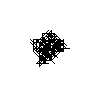

In [ ]:
visualize(x[0])

In [ ]:
y[0]

tensor([0.])

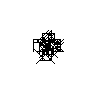

In [ ]:
visualize(x[1])

In [ ]:
y[1]

tensor([1.])

## Data frame

In [ ]:
# df = MSDataFrame(generate_batch, repeat = 3, size = 100)
# df.info()

In [ ]:
df = MSDataFrame(generate_batch, repeat = 1, size = 25)
df.info()

Number of mini-batches stored: 25
Number of times a mini-batch is used: 8
Number of mini-batches created: 25


In [ ]:
x,y = df.read()

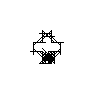

In [ ]:
visualize(x[0])

In [ ]:
x.shape, y.shape

(torch.Size([100, 1, 94, 94]), torch.Size([100, 1]))

## Model

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 40, stride = 3, kernel_size = 13, padding = 0),
    torch.nn.AdaptiveMaxPool2d(1),
    torch.nn.Flatten(),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 1)
)

In [ ]:
y_pred = net(x)

In [ ]:
y_pred.shape

torch.Size([100, 1])

In [ ]:
def accuracy_func(outputs, labels):
    return ((outputs > 0.5) == labels).float().mean()

In [ ]:
accuracy_func(y_pred, y)

tensor(0.5000)

## Training

In [ ]:
loss_func = torch.nn.MSELoss()

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
n_epochs = 40
length = 25

In [ ]:
for epoch in trange(n_epochs):
    running_loss = 0.0
    for i in range(length):
        inputs, labels = df.read()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        df.iterate()
        running_loss += loss.item()
    print('[%d]  loss: %.3f   accuracy: %.2f' %
          (epoch, running_loss / length,
           accuracy_func(outputs, labels)))

[0]  loss: 0.289   accuracy: 0.75
[1]  loss: 0.186   accuracy: 0.73
[2]  loss: 0.163   accuracy: 0.76
[3]  loss: 0.148   accuracy: 0.77
[4]  loss: 0.134   accuracy: 0.79
[5]  loss: 0.127   accuracy: 0.84
[6]  loss: 0.119   accuracy: 0.80
[7]  loss: 0.115   accuracy: 0.81
[8]  loss: 0.111   accuracy: 0.86
[9]  loss: 0.113   accuracy: 0.87
[10]  loss: 0.114   accuracy: 0.91
[11]  loss: 0.114   accuracy: 0.84
[12]  loss: 0.110   accuracy: 0.88
[13]  loss: 0.110   accuracy: 0.90
[14]  loss: 0.109   accuracy: 0.87
[15]  loss: 0.106   accuracy: 0.88
[16]  loss: 0.106   accuracy: 0.88
[17]  loss: 0.099   accuracy: 0.90
[18]  loss: 0.091   accuracy: 0.92
[19]  loss: 0.090   accuracy: 0.92
[20]  loss: 0.094   accuracy: 0.91
[21]  loss: 0.096   accuracy: 0.93
[22]  loss: 0.099   accuracy: 0.90
[23]  loss: 0.089   accuracy: 0.91
[24]  loss: 0.092   accuracy: 0.90
[25]  loss: 0.093   accuracy: 0.88
[26]  loss: 0.083   accuracy: 0.93
[27]  loss: 0.088   accuracy: 0.91
[28]  loss: 0.085   accuracy: 

In [ ]:
df.info()

Number of mini-batches stored: 25
Number of times a mini-batch is used: 8
Number of mini-batches created: 150


**TO DO:**
- try to add more intermediate channels in ConvNet
- try adding another linear layer (?)
- implement validation check and examine mistakes

**Question:** is it possible to visualize the first layer of the convnet?